# ROB2004 Final Project - manipulation of objects

The goal of this project is to solve a simple manipulation task.

## Instructions
* Solve the problem below.
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a report (maximum 3 pages) in pdf format detailing the methodology you followed to solve the problem. You should add plots in the report (does not count for the page limit).
* This is an individual project (dual submission of code/report is not allowed)

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

To run this project, you need to install Mujoco and Pinocchio. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Problem

Implement controller(s) using the code skeleton below to get the robot to put the red cube inside the bowl and the blue cube on top of the tower of green cubes (without breaking the tower!).

<div>
<img src="./manipulation_scene.jpg" width="400"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy, scipy, cvxopt or proxQP
* You need to use at least one task-space controller
* You need to use at least one joint-space controll (with an inverse geometry method)
* You need to compensate for the gravity of the robot

In your report, describe the controllers you designed and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit). Do not copy-paste code in the report.

## Scene details
* The bowl is located 25cm forward and 40cm right of the robot.
* The green tower is located 35cm forward and 50cm to the left of the robot
* The blue cube is located 45cm forward and 20cm to the left of the robot
* The red cube is located 50cm in front of the robot
* The x axis of the robot base is pointing foward and its y axis is pointing to its left


In [1]:
# setup some librairies and display options
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import time

# be careful we will only print the first 4 digits and round small numbers in arrays
np.set_printoptions(suppress=True, precision=4)

# this library contains the simulation and helper functions for the robot
from MujocoSim import FR3Sim

In [2]:
# this creates the simulation environment
my_robot = FR3Sim()

In [3]:
# HELPER FUNCTIONS

def translate(vector):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[0,3] = vector[0]
    transform[1,3] = vector[1]
    transform[2,3] = vector[2]

    ### we return the object
    return transform

def rotateX(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[1,1] = np.cos(angle)
    transform[1,2] = -np.sin(angle)
    transform[2,1] = np.sin(angle)
    transform[2,2] = np.cos(angle)
    
    ### we return the object
    return transform

def rotateY(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[0,0] = np.cos(angle)
    transform[0,2] = np.sin(angle)
    transform[2,0] = -np.sin(angle)
    transform[2,2] = np.cos(angle)
    
    ### we return the object
    return transform

def rotateZ(angle):
    # we allocate a 4x4 array (as identity since this corresponds to no motion)
    transform = np.eye(4)
    
    # here you can fill the rest of the transform
    ##WRITE CODE HERE
    transform[0,0] = np.cos(angle)
    transform[0,1] = -np.sin(angle)
    transform[1,0] = np.sin(angle)
    transform[1,1] = np.cos(angle)
    
    ### we return the object
    return transform

def forward_kinematics(q):

    theta = [np.pi/2, -np.pi/2]  

    l0 = 0.333
    l1 = -0.316
    l2 = 0.0825
    l3 = -0.0825
    l4 = 0.384
    l5 = 0.088
    l6 = 0.107

    T_01 = translate([0,0,l0]) @ rotateZ(q[0])
    T_12 = rotateX(theta[1]) @ rotateZ(q[1])  
    T_23 = translate([0,l1,0]) @ rotateX(theta[0]) @ rotateZ(q[2])
    T_34 = translate([l2,0,0]) @ rotateX(theta[0]) @ rotateZ(q[3])
    T_45 = translate([l3,l4,0]) @ rotateX(theta[1]) @ rotateZ(q[4])  
    T_56 = rotateX(theta[0]) @ rotateZ(q[5])
    T_67 = translate([l5,0,0]) @ rotateX(theta[0]) @ rotateZ(q[6])
    T_7F = translate([0,0,l6])

    FK = T_01 @ T_12 @ T_23 @ T_34 @ T_45 @ T_56 @ T_67 @ T_7F
    return FK

def compute_trajectory(position_init, position_goal, t_init, t_goal, t):
    T = t_goal - t_init
    t_diff = t - t_init
    pos_diff = position_goal - position_init

    desired_position = position_init + (10*(t_diff/T)**3 - 15*(t_diff/T)**4 + 6*(t_diff/T)**5) * (pos_diff)
    desired_velocity = (30*(t_diff**2)/(T**3) - 60*(t_diff**3)/(T**4) + 30*(t_diff**4)/(T**5)) * (pos_diff)
    
    return desired_position, desired_velocity

def fingertip_position_error(joint_angles, desired_robot_position):
    current_guess_position = my_robot.get_pose(joint_angles)[0:3,3]
    error = current_guess_position - desired_robot_position
    return error.dot(error)

def inverse_geometry(desired_robot_position):
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi),]
    x0, _ = my_robot.get_state()
    res = scipy.optimize.minimize(fingertip_position_error,x0, args=(desired_robot_position,),bounds=bounds)
    return res.x

In [ ]:
# FUNCTION TESTING

q, dq = my_robot.get_state()
print(q, dq)

print()

gravity = my_robot.get_gravity(q)
print(gravity)

print()

jacobian = my_robot.get_jacobian(q)
print(jacobian)

print()

T_sim = my_robot.get_pose(q)
print(T_sim)


In [ ]:
my_robot.reset()

In [ ]:
# Object locations 
object_locations = {
    "bowl": np.array([0.25, -0.4, 0]),
    "tower": np.array([0.35, 0.5, 0]),
    "blue_cube": np.array([0.45, 0.2, 0.02]), 
    "red_cube": np.array([0.5, 0, 0.02])
}

# Movement parameters 
movement_params = {
    "high_approach": 0.4,      
    "blue_grasp": 0.12,         
    "red_grasp": 0.13,          
    "transport_height": 0.4,    
    "tower_approach": 0.335,    
    "placement_offset": 0.435    
}

# Movement sequence 
movement_plan = [
    # Blue cube sequence
    {"target": np.array([0.5, 0.2, movement_params["high_approach"]]), "grip": False},
    {"target": np.array([0.45, 0.2, movement_params["blue_grasp"]]), "grip": False},
    {"target": np.array([0.5, 0.2, movement_params["high_approach"]]), "grip": True},
    {"target": np.array([0.34, 0.504, movement_params["tower_approach"]]), "grip": True},
    {"target": np.array([0.35, 0.5, movement_params["placement_offset"]]), "grip": False},
    
    # Red cube sequence
    {"target": np.array([0.55, 0, movement_params["high_approach"]]), "grip": False},
    {"target": np.array([0.55, 0, movement_params["red_grasp"]]), "grip": False},
    {"target": np.array([0.55, 0, movement_params["high_approach"]]), "grip": True},
    {"target": np.array([0.3, -0.4, movement_params["high_approach"]]), "grip": True},
    {"target": np.array([0.3, -0.4, movement_params["placement_offset"]]), "grip": False}
]


phase_durations = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

# PD gains 
control_params = {
    "P": np.array([120, 120, 120, 120, 120, 120, 120]),
    "D": np.array([100, 100, 100, 100, 100, 100, 100]),
    "grasp_force": -10,
    "release_force": 10
}

# Establishing variables (time)
current_phase = 0
total_time = sum(phase_durations)
dt = 0.001
num_steps = int(total_time / dt)
start_time = time.time()

# Establishing variables (plotting)
sim_data = {
    "timestamps": np.zeros(num_steps),
    "actual_pos": np.zeros((num_steps, 3)),
    "target_pos": np.zeros((num_steps, 3)),  
    "actual_vel": np.zeros((num_steps, 3)),  
    "target_vel": np.zeros((num_steps, 3)),  
    "joint_angles": np.zeros((num_steps, 3)),
    "joint_vel": np.zeros((num_steps, 3))
}

# Establishing variables (positions)
q, dq = my_robot.get_state()
current_pose = my_robot.get_pose(q)
start_pos = current_pose[0:3, 3]
phase_start_time = 0

# Control loop
for i in range(num_steps):
    current_time = i * dt
    sim_data["timestamps"][i] = current_time
    
    # Get current state
    q, dq = my_robot.get_state()
    current_pose = my_robot.get_pose(q)
    R = current_pose[0:3, 0:3]
    sim_data["actual_pos"][i] = current_pose[0:3, 3]
    current_pos = sim_data["actual_pos"][i]

    # Phase transition logic 
    elapsed_time = 0
    for j, duration in enumerate(phase_durations):
        elapsed_time += duration
        if current_time < elapsed_time:
            if current_phase != j:
                phase_start_time = current_time
                start_pos = current_pos.copy()
            current_phase = j
            break
    
    # Get current target 
    phase = movement_plan[current_phase]
    target_pos = phase["target"]
    grip_cmd = control_params["grasp_force"] if phase["grip"] else control_params["release_force"]
    
    # Trajectory generation 
    desired_pos, desired_vel = compute_trajectory(
        start_pos, target_pos, phase_start_time,
        phase_start_time + phase_durations[current_phase],
        current_time
    )
    
    # Store trajectory data
    sim_data["target_pos"][i] = desired_pos
    sim_data["target_vel"][i] = desired_vel
    
    # Calculate errors
    J = my_robot.get_jacobian(q)
    J_world = R @ J[3:, :]  
    current_vel = J_world @ dq
    sim_data["actual_vel"][i] = current_vel
    
    pos_error = desired_pos - current_pos
    vel_error = desired_vel - current_vel
    
    # Task and joint space controllers
    if np.linalg.norm(pos_error) <= 0.01:
        if current_phase == 1:  # Grabbing blue cube
            q_des = inverse_geometry(movement_plan[0]["target"])
            dq_des = np.array([0, 0, 0, 0, 0, 0.4, 0.1])
            torque = (control_params["P"] * (q_des - q) + 
                     control_params["D"] * (dq_des - dq))
        elif current_phase == 3:  # Approaching tower
            q_des = inverse_geometry(movement_plan[2]["target"])
            dq_des = np.array([0, 0, 0, 0, -0.05, -0.2, 0.1])
            torque = (control_params["P"] * (q_des - q) + 
                     control_params["D"] * (dq_des - dq))
        elif current_phase == 6:  # Grabbing red cube
            q_des = inverse_geometry(movement_plan[5]["target"])
            dq_des = np.array([0, 0, 0, 0, 0.05, 0, -0.4])
            torque = (control_params["P"] * (q_des - q) + 
                     control_params["D"] * (dq_des - dq))
        else:
            torque = J_world.T @ (np.diag(control_params["P"][:3]) @ pos_error + 
                                 np.diag(control_params["D"][:3]) @ vel_error)
    else:
        torque = J_world.T @ (np.diag(control_params["P"][:3]) @ pos_error + 
                         np.diag(control_params["D"][:3]) @ vel_error)
    
    # Send torque to the robot
    torque += my_robot.get_gravity(q)
    my_robot.send_joint_torque(torque, grip_cmd)
    
    # Store joint data
    sim_data["joint_angles"][i] = q[4:]
    sim_data["joint_vel"][i] = dq[4:]
    
    # Maintain timing
    time.sleep(max(dt*(i+1) - (time.time()-start_time), 0))

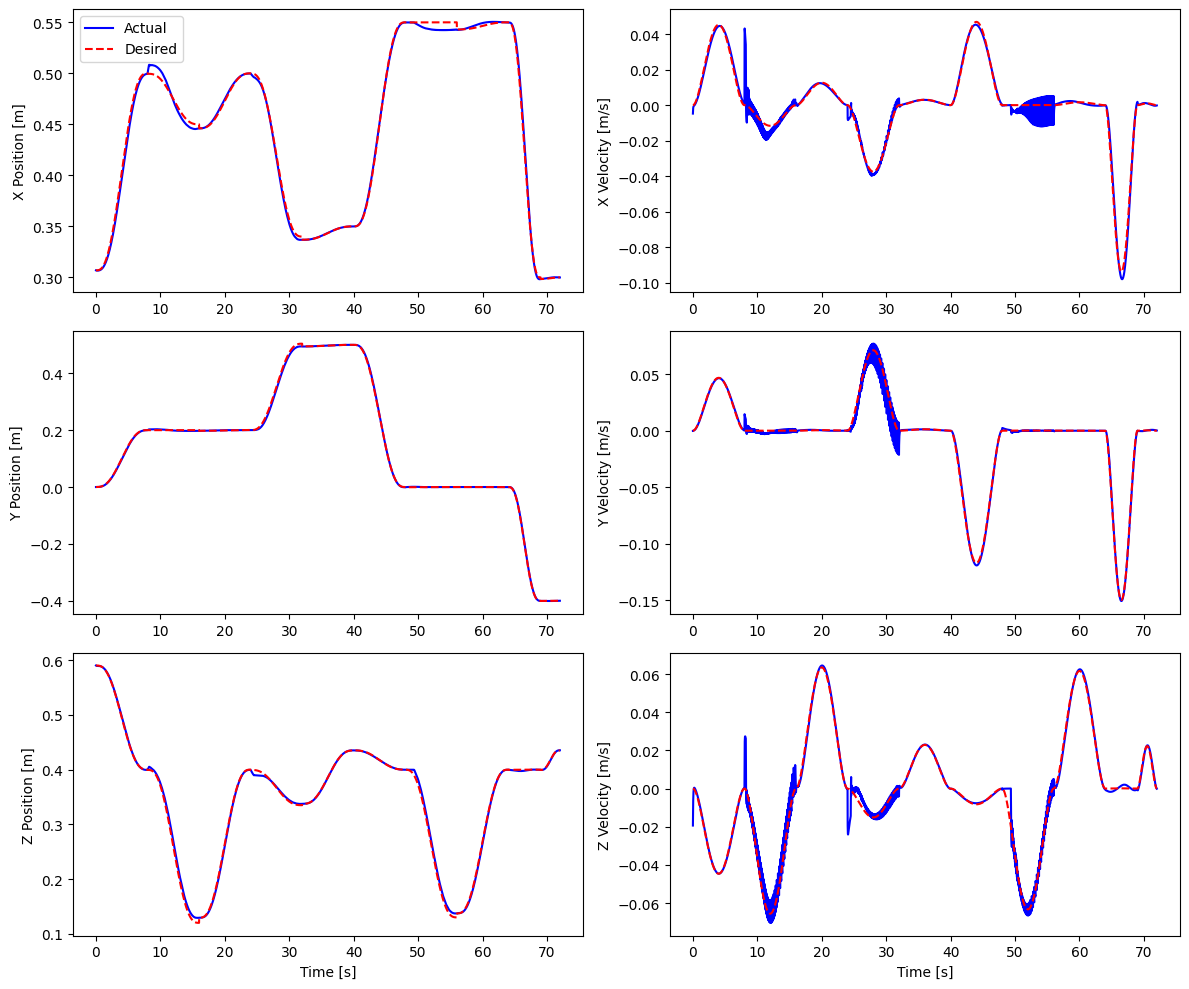

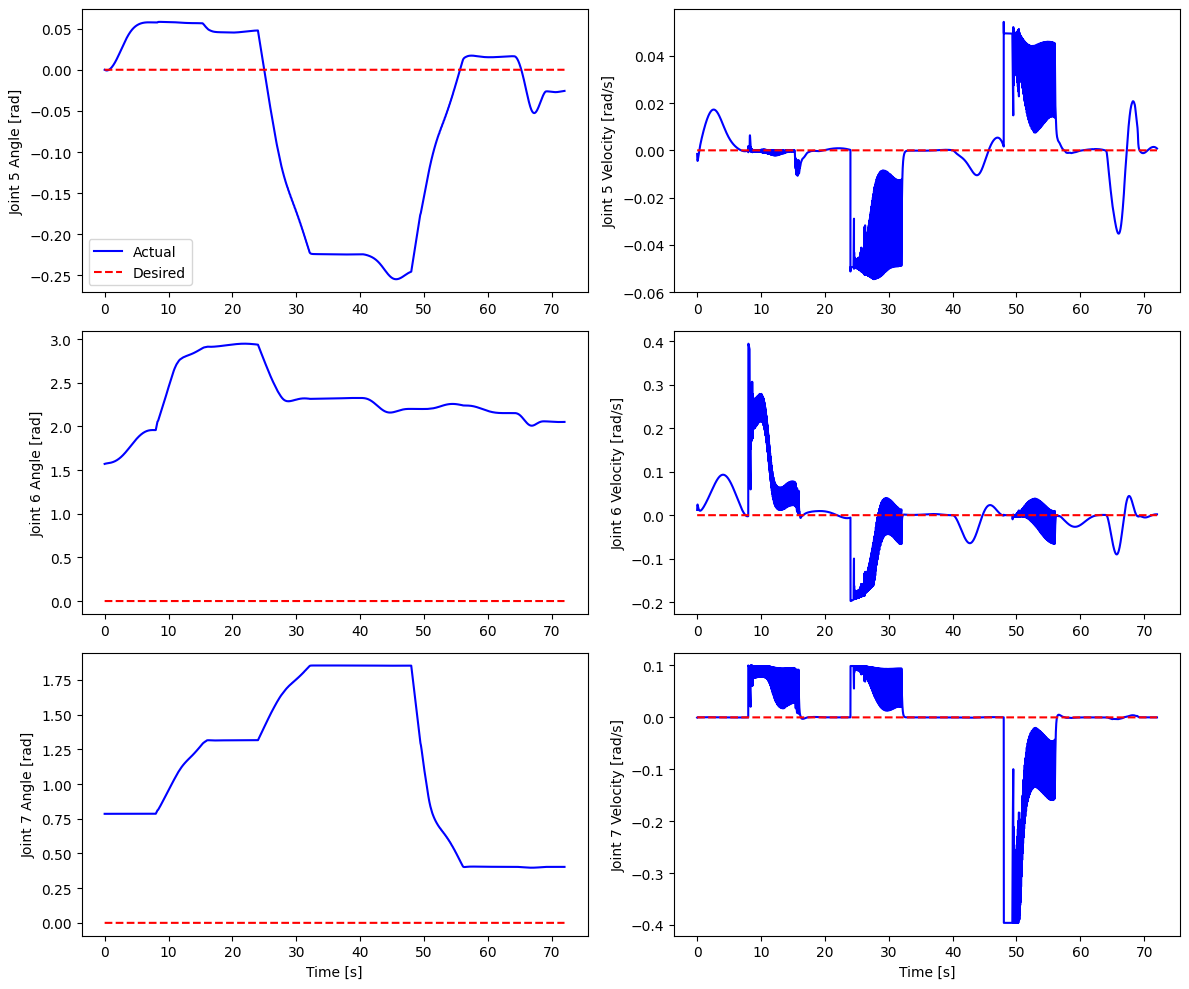

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_finger_posvel(time, measured_pos, desired_pos, measured_vel, desired_vel):
    fig = plt.figure(figsize=(12, 10))
    
    # Position Plots
    plt.subplot(3, 2, 1)
    plt.plot(time, measured_pos[:, 0], 'b-', label='Actual')
    plt.plot(time, desired_pos[:, 0], '--r', label='Desired')
    plt.ylabel('X Position [m]')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.plot(time, measured_pos[:, 1], 'b-')
    plt.plot(time, desired_pos[:, 1], '--r')
    plt.ylabel('Y Position [m]')
    
    plt.subplot(3, 2, 5)
    plt.plot(time, measured_pos[:, 2], 'b-')
    plt.plot(time, desired_pos[:, 2], '--r')
    plt.ylabel('Z Position [m]')
    plt.xlabel('Time [s]')

    # Velocity Plots
    plt.subplot(3, 2, 2)
    plt.plot(time, measured_vel[:, 0], 'b-')
    plt.plot(time, desired_vel[:, 0], '--r')
    plt.ylabel('X Velocity [m/s]')
    
    plt.subplot(3, 2, 4)
    plt.plot(time, measured_vel[:, 1], 'b-')
    plt.plot(time, desired_vel[:, 1], '--r')
    plt.ylabel('Y Velocity [m/s]')
    
    plt.subplot(3, 2, 6)
    plt.plot(time, measured_vel[:, 2], 'b-')
    plt.plot(time, desired_vel[:, 2], '--r')
    plt.ylabel('Z Velocity [m/s]')
    plt.xlabel('Time [s]')
    
    plt.tight_layout()
    plt.show()

def plot_joint567_angvel(time, measured_angles, desired_angles, measured_vel, desired_vel):
    fig = plt.figure(figsize=(12, 10))
    
    # Angle Plots
    plt.subplot(3, 2, 1)
    plt.plot(time, measured_angles[:, 0], 'b-', label='Actual')
    plt.plot(time, desired_angles[:, 0], '--r', label='Desired')
    plt.ylabel('Joint 5 Angle [rad]')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.plot(time, measured_angles[:, 1], 'b-')
    plt.plot(time, desired_angles[:, 1], '--r')
    plt.ylabel('Joint 6 Angle [rad]')
    
    plt.subplot(3, 2, 5)
    plt.plot(time, measured_angles[:, 2], 'b-')
    plt.plot(time, desired_angles[:, 2], '--r')
    plt.ylabel('Joint 7 Angle [rad]')
    plt.xlabel('Time [s]')

    # Velocity Plots
    plt.subplot(3, 2, 2)
    plt.plot(time, measured_vel[:, 0], 'b-')
    plt.plot(time, desired_vel[:, 0], '--r')
    plt.ylabel('Joint 5 Velocity [rad/s]')
    
    plt.subplot(3, 2, 4)
    plt.plot(time, measured_vel[:, 1], 'b-')
    plt.plot(time, desired_vel[:, 1], '--r')
    plt.ylabel('Joint 6 Velocity [rad/s]')
    
    plt.subplot(3, 2, 6)
    plt.plot(time, measured_vel[:, 2], 'b-')
    plt.plot(time, desired_vel[:, 2], '--r')
    plt.ylabel('Joint 7 Velocity [rad/s]')
    plt.xlabel('Time [s]')
    
    plt.tight_layout()
    plt.show()

# Generate plots using your data structure
plot_finger_posvel(
    sim_data["timestamps"], 
    sim_data["actual_pos"], 
    sim_data["target_pos"],
    sim_data["actual_vel"],
    sim_data["target_vel"]
)

plot_joint567_angvel(
    sim_data["timestamps"],
    sim_data["joint_angles"],
    np.zeros_like(sim_data["joint_angles"]),  # Placeholder for desired angles
    sim_data["joint_vel"],
    np.zeros_like(sim_data["joint_vel"])      # Placeholder for desired velocities
)